In [ ]:
import netket as nk
import jax
import jax.numpy as jnp
from jax.flatten_util import ravel_pytree
from itertools import product

n = 4          # number of visible units
alpha = 3        # hidden density => m = alpha * n
m = alpha * n

model = nk.models.RBM(alpha=alpha, param_dtype=jnp.float32)  

key = jax.random.PRNGKey(0)
key_W, key_b, key_a = jax.random.split(key, 3)

tau = 1.0         # weight scale (preactivation contribution)
sigma_b = 0.5     # hidden-bias scale

params = {
    "a": jnp.zeros((n,)),                                   # visible bias a
    "b": sigma_b * jax.random.normal(key_b, (m,)),           # hidden bias b
    "W": (tau / jnp.sqrt(n)) * jax.random.normal(key_W, (n, m)),  # weights W
}

def Energy(params, v):
    """
    Energy for a single configuration v in {-1,+1}^n:
    E(v) = -a^T v - sum_j log(2 cosh(b_j + (W^T v)_j))
    """
    a, b, W = params["a"], params["b"], params["W"]
    u = b + v @ W
    return - jnp.dot(a, v) - jnp.sum(jnp.log(2.0 * jnp.cosh(u)))


def ntk_closed_form(params, V):
    """
    Computes K = B + T T^T + B ⊙ (T T^T)
    where:
      B = V V^T
      U = V W + 1 b^T, T = tanh(U)
    """
    a, b, W = params["a"], params["b"], params["W"]
    U = V @ W + b  # (N, m)
    T = jnp.tanh(U)  # (N, m)
    B = V @ V.T      # (N, N)
    TT = T @ T.T     # (N, N)
    K = B + TT + B * TT
    return K

def ntk_autodiff(params, V):
    """
    K_ij = <∇_θ E(v_i), ∇_θ E(v_j)>
    Uses JAX to flatten params and build the Jacobian.
    """
    theta0, unravel = ravel_pytree(params)

    def E_flat(theta, v):
        p = unravel(theta)
        return Energy(p, v)

    # Gradient wrt flat theta
    grad_E = jax.grad(E_flat)

    # Stack gradients for all samples -> J (N x P)
    J = jax.vmap(lambda v: grad_E(theta0, v))(V)
    # NTK = J J^T
    K = J @ J.T
    return K

# key_data = jax.random.PRNGKey(123)
# V = jnp.where(jax.random.normal(key_data, (32, n)) > 0, 1.0, -1.0)  # (N=32, n)

V = configs = jnp.array(list(product([-1, 1], repeat=n))) # (N=2^n, n)

K_fast = ntk_closed_form(params, V)
K_auto = ntk_autodiff(params, V)

rel_err = jnp.linalg.norm(K_fast - K_auto) / (1e-9 + jnp.linalg.norm(K_fast))
print("Relative error (closed-form vs autodiff):", float(rel_err))

Relative error (closed-form vs autodiff): 2.7413268449563e-16


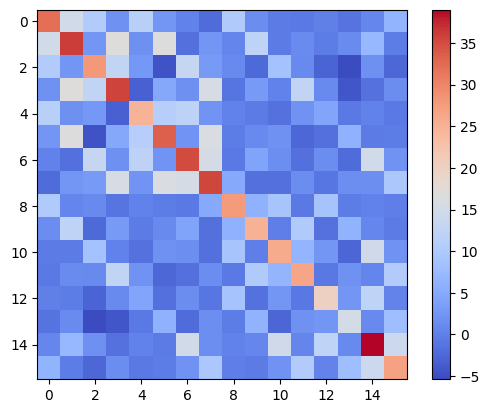

In [10]:
import matplotlib.pyplot as plt
import numpy as np

plt.imshow(K_fast, cmap='coolwarm')
plt.colorbar()

In [15]:
lmbd, eigvec = np.linalg.eigh(K_fast)

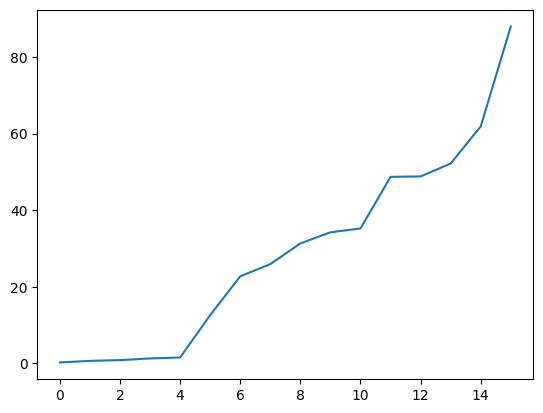

In [19]:
plt.plot(lmbd)

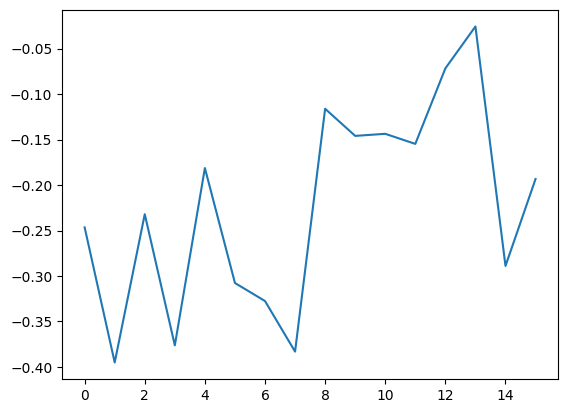

: 

In [ ]:
plt.plot(eigvec[:,-1])